In [21]:
from lacbox.io import ReadHAWC2
import matplotlib.pyplot as plt
import numpy as np

**VAWT parameters**

From Table 1 in [1].

In [22]:
BLADE_LENGTH = 1.8288  # length of blades
STRUT_LENGTH = 0.7874  # length of strut

RHO = 1.225  # air density

r = STRUT_LENGTH
l = BLADE_LENGTH
area = 2*r*l


**Solidity calculations**

Solidity equation with pi: https://fluids.princeton.edu/pubs/MillerDuvvuriHultmark2021.pdf  
Solidity equation without pi: https://iopscience.iop.org/article/10.1088/1742-6596/524/1/012125 (and other places)

Nicolau notes the largest solidity he saw without pi was 14%. However, Ang notes that solidity doesn't really matter as long as your Ct is in the desired range (around 0.8). A higher Ct (e.g., above 1.0) results in the aerodynamic models not working. This model has a very high solidity, but it's small, and the Ct is okay (verified below).

In [23]:
# solidity
Nb = 3
c = 0.15
sigma_wpi = Nb*c / (2*np.pi*r)
sigma_nopi = Nb*c / (2*r)
print(f'The solidity with pi is {sigma_wpi * 100:.1f}%')
print(f'The solidity without pi is {sigma_nopi * 100:.1f}%')

The solidity with pi is 9.1%
The solidity without pi is 28.6%


**Values from HAWC2**

In [24]:
fname = '../res/mudd_vawt_5sec.hdf5'

h2res = ReadHAWC2(fname)

names, units, desc = h2res.chaninfo
data = h2res.data

idx_rotspd = np.where(['Omega' in name for name in names])[0]
idx_aerothrust = np.where(['rot. thrust' in name for name in names])[0]
idx_aerotorque = np.where(['rot. torque' in name for name in names])[0]
idx_aeropower = np.where(['rot. power' in name for name in names])[0]
idx_wsp = np.where(['WSP gl. coo.,Vy' in name for name in names])[0]

omega_h2 = np.mean(data[:, idx_rotspd])  # rad/s
thrust_h2 = np.mean(data[:, idx_aerothrust]) * 1000  # N
torque_h2 = np.mean(data[:, idx_aerotorque]) * 1000  # Nm
power_h2 = np.mean(data[:, idx_aeropower]) * 1000  # W
wsp_h2 = np.mean(data[:, idx_wsp])  # m/s

Check Cp and Ct.

In [25]:
Ct_h2 = thrust_h2 / (0.5 * RHO * area * wsp_h2**2)
Cp_h2 = power_h2 / (0.5 * RHO * area * wsp_h2**3)

print(f'Ct from HAWC2: {Ct_h2:.4f}')
print(f'Cp from HAWC2: {Cp_h2:.4f}')

Ct from HAWC2: 0.9018
Cp from HAWC2: 0.4005


Check that $P = \tau \times \Omega$, just for sanity.

In [26]:
torque_h2_2 = power_h2 / omega_h2

print(f'Aero. torque from HAWC2: {torque_h2:.3f} Nm')
print(f'Paero/omega from HAWC2: {torque_h2_2:.3f} Nm')

Aero. torque from HAWC2: 2.398 Nm
Paero/omega from HAWC2: 2.398 Nm


Also load results for a different TSR.

In [27]:
fname = '../res/mudd_vawt_tsr5.2.hdf5'

h2res_2 = ReadHAWC2(fname)

names_2, units_2, desc_2 = h2res_2.chaninfo
data_2 = h2res_2.data

idx_rotspd_2 = np.where(['Omega' in name for name in names_2])[0]
idx_aerothrust_2 = np.where(['rot. thrust' in name for name in names_2])[0]
idx_aerotorque_2 = np.where(['rot. torque' in name for name in names_2])[0]
idx_aeropower_2 = np.where(['rot. power' in name for name in names_2])[0]
idx_wsp_2 = np.where(['WSP gl. coo.,Vy' in name for name in names_2])[0]

omega_h2_2 = np.mean(data_2[:, idx_rotspd_2])  # rad/s
thrust_h2_2 = np.mean(data_2[:, idx_aerothrust_2]) * 1000  # N
torque_h2_2 = np.mean(data_2[:, idx_aerotorque_2]) * 1000  # Nm
power_h2_2 = np.mean(data_2[:, idx_aeropower_2]) * 1000  # W
wsp_h2_2 = np.mean(data_2[:, idx_wsp_2])  # m/s

**Theoretical values versus wind speed**

For two different TSRs, each with an assumed Cp. From Table 3/Section 5.3 in [1]. Add HAWC2 simulations on top.

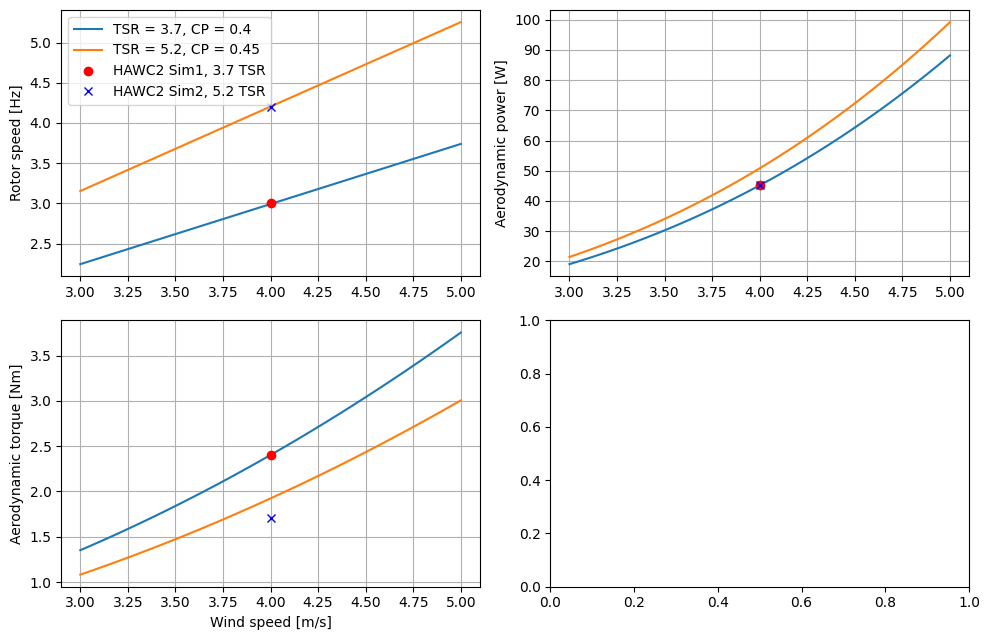

In [29]:
CP_TSRs = [(0.4, 3.7), (0.45, 5.2)]  # assumed TSR and power coefficient (Table 3/5.3 in [1])

# things versus wind speed for different TSRs (CPs)
fig, axs = plt.subplots(2, 2, figsize=(10, 6.5))
wsps = np.linspace(3, 5)

ax0, ax1, ax2, ax3 = axs.flatten()

for (cp, tsr) in CP_TSRs:
    aero_power = 0.5 * RHO * cp * area * wsps**3 #  aerodynamic power[W]

    rot_speeds_radps = tsr * wsps / r  # rotor speeds [radps]
    rot_speeds_hz = rot_speeds_radps / 2 / np.pi  # rotor speed [Hz]

    aero_torque = aero_power / rot_speeds_radps  # aerodynamic torque [N]

    ax0.plot(wsps, rot_speeds_hz, label=f'TSR = {tsr}, CP = {cp}')
    ax1.plot(wsps, aero_power)
    ax2.plot(wsps, aero_torque)

# add h2 values from first tsr
ax0.plot(wsp_h2, omega_h2/2/np.pi, 'ro', label='HAWC2 Sim1, 3.7 TSR')
ax1.plot(wsp_h2, power_h2, 'ro')
ax2.plot(wsp_h2, torque_h2, 'ro')

# add h2 values from second tsr
ax0.plot(wsp_h2_2, omega_h2_2/2/np.pi, 'bx', label='HAWC2 Sim2, 5.2 TSR')
ax1.plot(wsp_h2_2, power_h2_2, 'bx')
ax2.plot(wsp_h2_2, torque_h2_2, 'bx')

ax0.set(ylabel='Rotor speed [Hz]')
ax1.set(ylabel='Aerodynamic power [W]')
ax2.set(xlabel='Wind speed [m/s]', ylabel='Aerodynamic torque [Nm]')
ax0.grid()
ax1.grid()
ax2.grid()
ax0.legend()
fig.tight_layout()

**References**

1. https://docs.google.com/document/d/1QnHV33jAytV1AOFISvGnWSSIhK93EyPyHkHIg6Wc2Xw/edit?tab=t.0#heading=h.74ak1339whz6